<img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" >

# Montecarlo Simulation of Facebook, Amazon, Apple & Microsoft

**Optimal portfolio Mean-Variance Markowitz Approach**

Import the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

Download the stock prices

In [2]:
symbols = ["FB", "AMZN", "AAPL", "MSFT"]
rawdata = yf.download(symbols, start="2019-01-01", end="2020-05-01")
rawdata = rawdata['Close']

[*********************100%***********************]  4 of 4 completed


Calculate Returns

In [3]:
returns = np.log(rawdata/rawdata.shift(1)).dropna()
returns.head()

,AAPL,AMZN,FB,MSFT
Date,,,,
2019-01-03,-0.104924,-0.025566,-0.029469,-0.037482
2019-01-04,0.041803,0.048851,0.046061,0.045460
2019-01-07,-0.002228,0.033776,0.000725,0.001275
2019-01-08,0.018884,0.016476,0.031937,0.007225
2019-01-09,0.016839,0.001713,0.011857,0.014198


### Histogram of Returns & Correlations

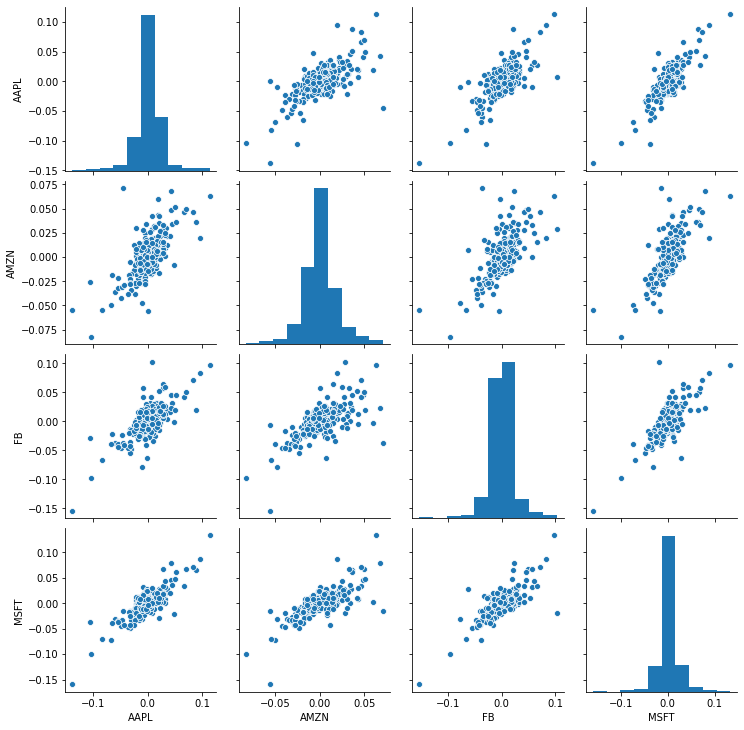

In [4]:
sns.pairplot(data=returns)
plt.show()

### Monte Carlo Simulation of 2,500 portfolios

In [5]:
np.random.seed(21)
num_ports = 2500
all_weights = np.zeros((num_ports, len(returns.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
risk_free = 0.01

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (returns.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ( ret_arr[x]- risk_free) /vol_arr[x]

### Printing Results

In [6]:
print("Max Sharpe Ratio using MC Simulation: {:.3f}".format(sharpe_arr.max()))
#print("Its location: {}".format(sharpe_arr.argmax()))

w = [round(i*100,2)for i in all_weights[sharpe_arr.argmax(),:]]
w = pd.DataFrame(w, columns = ['Weight (%)'], index = returns.columns)

print("\n")
print(w)

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

min_vol_ret = ret_arr[vol_arr.argmin()]
min_vol_vol = vol_arr[vol_arr.argmin()]

max_ret_ret = ret_arr[ret_arr.argmax()]


Max Sharpe Ratio using MC Simulation: 1.289


      Weight (%)
AAPL       40.01
AMZN       40.66
FB          0.21
MSFT       19.12


### Scatter Plot with Portfolio Returns

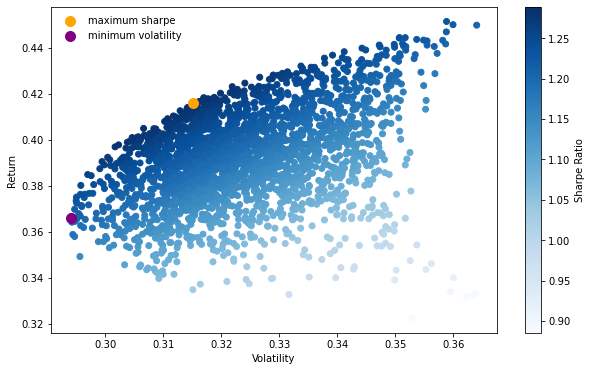

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='Blues')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='orange', s=100, label='maximum sharpe') # red dot
plt.scatter(min_vol_vol, min_vol_ret,c='purple', s=100, label='minimum volatility') # black dot
plt.legend(frameon=False)
plt.show()

### Optimizer to find best Sharpe Ratio Portfolio

In [40]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

# Set constrains and initial guess
cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

opt_results = sco.minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints=cons)

print("Optimal weights:")
print(opt_results['x'].round(2))
print("\n")
print("Indicators of optimal portfolio:")
ret_vol_sr = get_ret_vol_sr(opt_results.x)
print("Return {:.3f}, Volatility {:.3f}, Sharpe {:.3f}".format(ret_vol_sr[0], ret_vol_sr[1],ret_vol_sr[2]))




Optimal weights:
[0.38 0.5  0.   0.13]


Indicators of optimal portfolio:
Return 0.409, Volatility 0.309, Sharpe 1.324


### Creating Efficient Frontier

In [9]:
frontier_y = np.linspace(min_vol_ret,max_ret_ret)

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = sco.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

### Graph Frontier

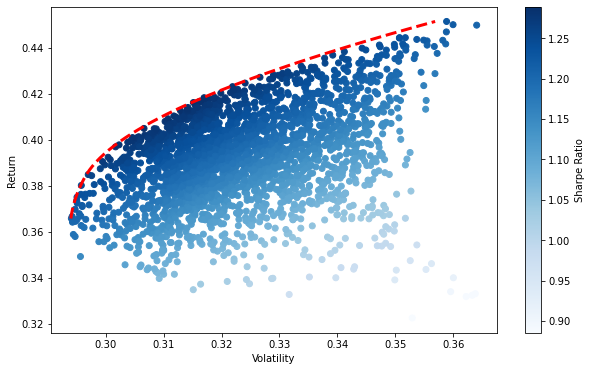

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='Blues')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
#plt.savefig('cover.png')
plt.show()


<img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" > <br>